# Damage Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02c import *

### Data

In [3]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks')]

In [7]:
annots = pd.read_csv(SOURCE/'classification_images'/'class_labels_tiny.csv')

In [8]:
annots.head(), annots.shape

(      damage                                   uid
 0  no-damage  7ae792ae-64b5-41ec-be7b-14873c450650
 1  no-damage  4ca98eb5-10bd-4d75-b3b3-3b9012291c1f
 2  no-damage  22e5eb6a-f924-4b27-9cb0-90b112bcfd66
 3  no-damage  e2ef0265-66e4-4104-a1a9-3fa985275a1d
 4  no-damage  e4e531da-2183-440a-9501-66873422625e, (898, 2))

In [9]:
annots.damage.value_counts()

no-damage        670
minor-damage      80
major-damage      78
destroyed         56
un-classified     14
Name: damage, dtype: int64

In [10]:
#export
def combine_nodamage_unclassified(annots):
    base_level = 'no-damage/un-classified'
    df = annots.copy()
    df.damage.replace('no-damage', base_level, inplace=True)
    df.damage.replace('un-classified', base_level, inplace=True)
    return df

In [11]:
annots = combine_nodamage_unclassified(annots)
annots.damage.value_counts()

no-damage/un-classified    684
minor-damage                80
major-damage                78
destroyed                   56
Name: damage, dtype: int64

In [13]:
fnames = [SOURCE/'classification_images'/f'{o}.png' for o in annots.uid]
fnames[:3]

[PosixPath('data/train/classification_images/7ae792ae-64b5-41ec-be7b-14873c450650.png'),
 PosixPath('data/train/classification_images/4ca98eb5-10bd-4d75-b3b3-3b9012291c1f.png'),
 PosixPath('data/train/classification_images/22e5eb6a-f924-4b27-9cb0-90b112bcfd66.png')]

In [14]:
val_idx = get_random_val_idx(len(fnames))    

In [15]:
#export
def get_label(annots, fname): 
    return annots[annots.uid == fname.stem].damage.values[0]

In [16]:
cats = list(annots.damage.value_counts().index)
cats

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

In [17]:
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(partial(get_label, annots), classes=cats))

In [18]:
bs = 8
sz = 64 #512
tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [19]:
data

ImageDataBunch;

Train: LabelList (809 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified
Path: .;

Valid: LabelList (89 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
minor-damage,no-damage/un-classified,major-damage,no-damage/un-classified,no-damage/un-classified
Path: .;

Test: None

minor-damage
data/train/classification_images/dc291028-427b-4771-b005-3f35cec67387.png


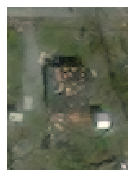

In [20]:
idx = 11
data.valid_ds.x[idx].show()
print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

In [21]:
data.train_ds.classes

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

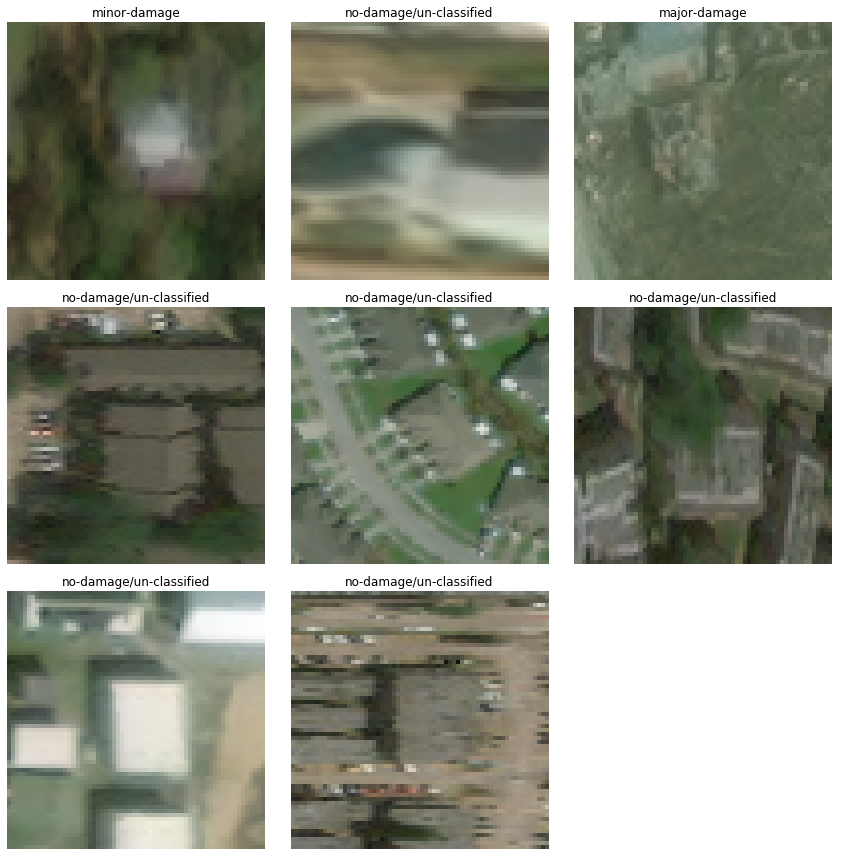

In [22]:
data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [23]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training

In [25]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


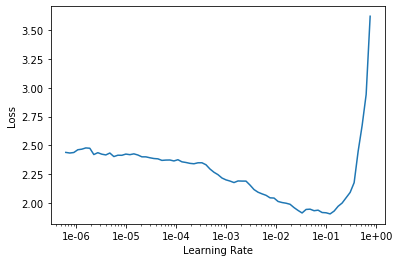

In [59]:
learn.recorder.plot()

In [60]:
lr = 1e-2

In [61]:
learn.fit_one_cycle(1, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.770817,0.861595,0.258427,00:19


In [63]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.009323,0.818459,0.213483,00:17
1,0.881529,1.472590,0.337079,00:17
2,0.875073,0.637081,0.269663,00:17
3,0.767877,0.471066,0.202247,00:17
4,0.671327,0.450524,0.202247,00:17


In [64]:
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.507649,0.482108,0.168539,00:17
1,0.543812,0.628817,0.168539,00:17
2,0.597118,1.048085,0.303371,00:17
3,0.660338,0.760741,0.247191,00:17
4,0.621974,0.431341,0.179775,00:17
5,0.605951,0.430387,0.202247,00:17
6,0.554475,0.285629,0.123596,00:17
7,0.510151,0.302275,0.123596,00:17
8,0.457609,0.271911,0.101124,00:17
9,0.417087,0.280145,0.101124,00:17


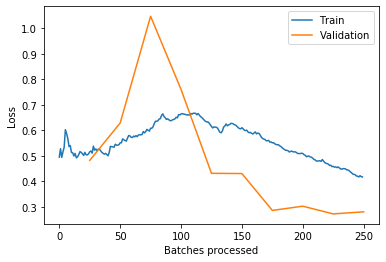

In [65]:
learn.recorder.plot_losses()

In [27]:
learn.save('damg_classifier_sz64.pth') #'classifier_sz512_bs32_resnet50_stage1')
learn.load('damg_classifier_sz64.pth'); #'classifier_sz512_bs32_resnet50_stage1');

### Infer on single image

In [51]:
idx = 56
img = open_image(data.valid_ds.items[idx])

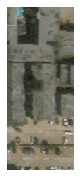

In [52]:
img.show()

In [53]:
learn.predict(img)

(Category destroyed, tensor(3), tensor([0.1555, 0.0824, 0.0764, 0.6857]))

In [54]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [55]:
uids = [o.stem for o in list(data.valid_ds.items[:10])]

In [56]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,c15596ac-4eb0-4b1d-b571-d50b1c801008,major-damage
1,92bbf9d9-1cf2-484b-9036-27d29688f3d1,major-damage
2,c4c3f3db-1ddc-4a92-9c0e-c845b843c798,destroyed
3,a076c71f-1c4b-433f-b09f-2703c7bb5566,destroyed
4,243367db-8fe8-4ca3-8052-127f4a111c75,destroyed
5,6a922125-7028-469b-9f17-717f40ef04b7,destroyed
6,43f60755-03b0-45ec-9fb0-e9dd98fbbb34,major-damage
7,534e1ee8-18ee-4d6e-8f6f-fc75ef856cff,destroyed
8,c1114292-2975-4be1-a713-855dd8da9ab9,destroyed
9,d0357850-07fa-440c-8290-9fa432cf7455,destroyed


# -fin

In [68]:
! python notebook2script.py 03_damage_classification.ipynb

Converted 03_damage_classification.ipynb to xview2comp/nb_03.py
